# **Seminar 2 - Attention и Transformer**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

## 1. Построим Transformer с нуля в Pytorch

<img src="https://i.pinimg.com/736x/c1/83/1a/c1831a58ecc935fc0f2ef4d35ce4fddb.jpg">

In [1]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Multi-head Attention

#### Основной класс - MultiHeadAttention

**Инициализация:**
* _in_size_ ~ размер эмбеддингов на входе
* _head_size_ ~ размер эмбеддингов матриц Q, K, V после преобразования
* _num_heads_ ~ число голов
* _out_size_ ~ размер эмбеддингов на выходе
* _query_in_size_ ~ размер эмбеддингов на входе для query (если None, то in_size)

**Forward:**
* _query, key, value_ ~ 3 тензора (по одному под Q, K и V преобразования - это ещё не сами тензоры $\text{batch\_size} \times seq \times d_k$, а тензоры $\text{batch\_size} \times seq \times \text{in\_size}$)
* _mask_ ~ булева маска для Masked Multi-head Attention (в декодере)

$$ Attention(Q, K, V) = softmax\Bigg(\frac{QK^T}{\sqrt{d_k}}\Bigg) \cdot V $$
$$ MultiHead(Q, K, V) = Concat(head_1, ..., head_H) \cdot W^O \quad ; \quad head_i = Attention(Q W_i^Q, K W_i^K, V W_i^V)$$

In [2]:
torch.exp(-torch.tensor([torch.inf]))

tensor([0.])

In [10]:
class MultiHeadAttention(nn.Module):
    """
    Class to calculate Multi-head attention (or Masked Multi-head attention for decoder) operation
    """
    def __init__(self, in_size, head_size, num_heads, out_size, query_in_size=None):
        """
        Args:
            in_size: embedding size of input
            head_size: hidden size of Q, K, V matrices
            num_heads: number of heads
            out_size: output embedding size
            query_in_size: embedding size of input for query (if not provided - same as in_size)
        """
        super(MultiHeadAttention, self).__init__()

        # Запишем все переданые гиперпараметры слоя
        self.in_size = in_size
        self.head_size = head_size
        self.num_heads = num_heads
        self.out_size = out_size
        self.query_in_size = self.in_size if query_in_size is None else query_in_size
       
        # Линейные преобразования для Q, K, V матриц (сразу хотим получить все Q, K, V матрицы)
        self.query_matrix = nn.Linear(self.query_in_size, self.head_size*self.num_heads, bias=False)
        self.key_matrix = nn.Linear(self.in_size, self.head_size*self.num_heads, bias=False)
        self.value_matrix = nn.Linear(self.in_size, self.head_size*self.num_heads, bias=False)
        
        # Линейное преобразование для получения выхода после конкатенации голов
        self.out = nn.Linear(self.head_size*self.num_heads, self.out_size, bias=False)

    def forward(self, query, key, value, mask=None):
        """
        Args:
           query : tensor for query
           key : tensor for key
           value : tensor for value
           mask: mask for decoder
        
        Returns:
           output vector from multihead attention
        """
        # Тензоры приходят размера batch_size x seq_len x in_size
        batch_size = key.size(0)
        seq_len = key.size(1)
        
        # Число токенов в query будет другим для decoder-а
        query_seq_len = query.size(1)
       
        # Применяем линейные преобразования на входе
        q = self.query_matrix(query)  # (batch_size, query_seq_len, head_size * num_heads)
        k = self.key_matrix(key)  # (batch_size, seq_len, head_size * num_heads)
        v = self.value_matrix(value)  # (batch_size, seq_len, head_size * num_heads)

        # .reshape / .view, .transpose
        q = q.reshape(batch_size, query_seq_len, self.num_heads, self.head_size).transpose(1,2)  # (batch_size, num_heads, query_seq_len, head_size)
        k = k.reshape(batch_size, seq_len, self.num_heads, self.head_size).transpose(1,2)  # (batch_size, num_heads, seq_len, head_size)
        v = v.reshape(batch_size,  seq_len, self.num_heads, self.head_size).transpose(1,2)  # (batch_size, num_heads, seq_len, head_size)
       
        # Считаем релевантность
        relevance = q @ k.transpose(2, 3) / math.sqrt(self.head_size)  # (batch_size, num_heads, query_seq_len, seq_len)
        
        # Если есть маска (для декодера), то заполняем значения по маске как минус бесконечность (чтобы exp(r) = 0 в softmax)
        if mask is not None:
             relevance = relevance.masked_fill(mask, -torch.inf)

        # Получаем вероятности
        relevance = F.softmax(relevance, -1)
 
        # Считаем выходы из каждой головы
        head_i = relevance @ v  # (batch_size, num_heads, query_seq_len, head_size)
        
        # Конкатенируем выходы
        concat = head_i.transpose(1,2).reshape(batch_size, query_seq_len, self.num_heads*self.head_size)  # (batch_size, query_seq_len, num_heads * head_size)
        
        return self.out(concat)  # (batch_size, query_seq_len, out_size)

#### Протестируем MultiHeadAttention для энкодера

In [11]:
tmp_layer = MultiHeadAttention(
    in_size=10,
    head_size=4,
    num_heads=3,
    out_size=15,
)

tmp_layer

MultiHeadAttention(
  (query_matrix): Linear(in_features=10, out_features=12, bias=False)
  (key_matrix): Linear(in_features=10, out_features=12, bias=False)
  (value_matrix): Linear(in_features=10, out_features=12, bias=False)
  (out): Linear(in_features=12, out_features=15, bias=False)
)

In [12]:
# Проверяем в обычном прямом проходе из энкодера
tmp_input = torch.rand(2, 5, 10)

print("Encoder-like input, no mask")
print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input, tmp_input, tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

Encoder-like input, no mask
Input shape: torch.Size([2, 5, 10])
Output shape: torch.Size([2, 5, 15])


#### Протестируем MultiHeadAttention для смеси энкодера и декодера

In [13]:
tmp_layer = MultiHeadAttention(
    in_size=10,
    head_size=4,
    num_heads=3,
    out_size=15,
    query_in_size=12,
)

tmp_layer

MultiHeadAttention(
  (query_matrix): Linear(in_features=12, out_features=12, bias=False)
  (key_matrix): Linear(in_features=10, out_features=12, bias=False)
  (value_matrix): Linear(in_features=10, out_features=12, bias=False)
  (out): Linear(in_features=12, out_features=15, bias=False)
)

In [14]:
# Проверяем в прямом проходе из декодера, где мы смешиваем информацию из энкодера и декодера
tmp_input_q = torch.rand(2, 5, 12)
tmp_input_kv = torch.rand(2, 7, 10)

print("Encoder+Decoder-like input, no mask")
print(f'Input Q shape: {tmp_input_q.shape}')
print(f'Input KV shape: {tmp_input_kv.shape}')

tmp_output = tmp_layer(tmp_input_q, tmp_input_kv, tmp_input_kv)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_q, tmp_input_kv, tmp_output

Encoder+Decoder-like input, no mask
Input Q shape: torch.Size([2, 5, 12])
Input KV shape: torch.Size([2, 7, 10])
Output shape: torch.Size([2, 5, 15])


#### Треугольная маска в декодере

In [15]:
def make_decoder_mask(decoder_embed):
    """
    Make mask for decoder Masked Multi-head Attention based on input sequence
    Args:
        decoder_embed: decoder sequence after embed
    Returns:
        mask: mask for Masked Multi-head Attention
    """
    batch_size, decoder_seq_len, _ = decoder_embed.shape
    mask = torch.tril(torch.ones((decoder_seq_len, decoder_seq_len))).expand(
        batch_size, 1, decoder_seq_len, decoder_seq_len
    ).bool()
    return mask 

#### Протестируем MultiHeadAttention для декодера с маской

Mask shape: torch.Size([1, 1, 10, 10])


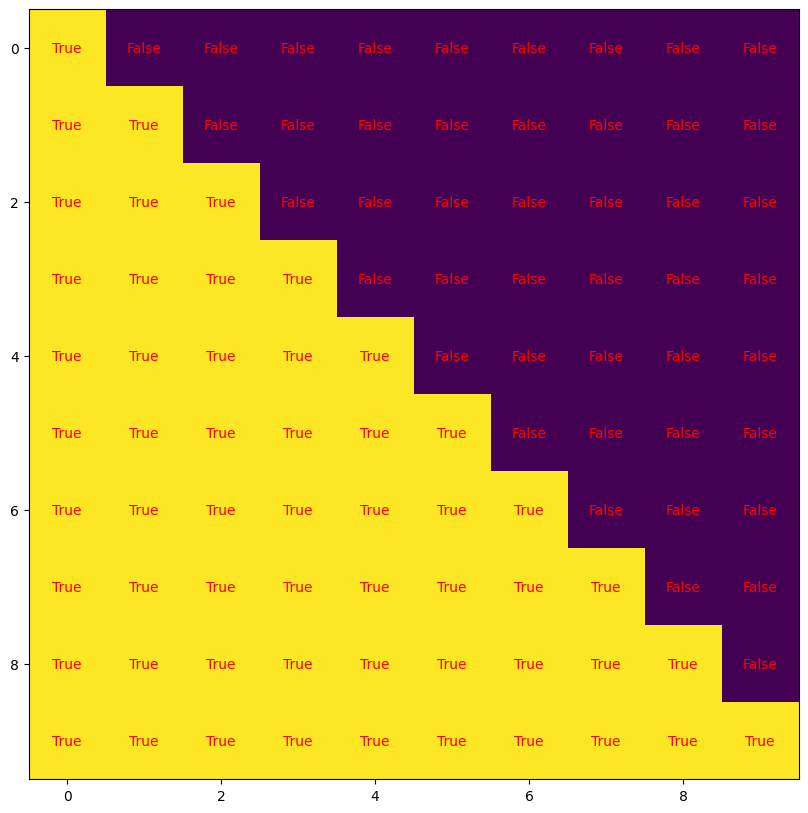

In [16]:
tmp_input = torch.rand(1, 10, 256)
tmp_mask = make_decoder_mask(tmp_input)
print(f"Mask shape: {tmp_mask.shape}")

# Визуализируем
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_mask[0, 0, :, :])
# Добавляем текстовые надписи
for i in range(tmp_mask.shape[-2]):
    for j in range(tmp_mask.shape[-1]):
        text = plt.text(j, i, tmp_mask[0, 0, i, j].item(), ha="center", va="center", color="red")
plt.show()

In [17]:
tmp_layer = MultiHeadAttention(
    in_size=10,
    head_size=4,
    num_heads=3,
    out_size=15,
)

tmp_layer

MultiHeadAttention(
  (query_matrix): Linear(in_features=10, out_features=12, bias=False)
  (key_matrix): Linear(in_features=10, out_features=12, bias=False)
  (value_matrix): Linear(in_features=10, out_features=12, bias=False)
  (out): Linear(in_features=12, out_features=15, bias=False)
)

In [18]:
tmp_input = torch.rand(2, 5, 10)
tmp_mask = make_decoder_mask(tmp_input)

print("Decoder-like input, with mask")
print(f'Input shape: {tmp_input.shape}')
print(f'Mask shape: {tmp_mask.shape}')

tmp_output = tmp_layer(tmp_input, tmp_input, tmp_input, tmp_mask)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_mask, tmp_output

Decoder-like input, with mask
Input shape: torch.Size([2, 5, 10])
Mask shape: torch.Size([2, 1, 5, 5])
Output shape: torch.Size([2, 5, 15])


### 1.2 Positional Encoding

#### Основной класс - PositionalEncoding

**Инициализация:**
* _max_seq_len_ ~ максимальный размер в токенах последовательности
* _emb_size_ ~ размер эмбеддингов на входе

**Forward:**
* _decoder_emb_ ~ эмбеддинги токенов из входа декодера

$$\text{PE}_{(\text{pos}, 2i)} = sin\Bigg( \frac{\text{pos}}{10000^{\frac{2i}{\text{emb\_size}}}} \Bigg) \quad ; \quad \text{PE}_{(\text{pos}, 2i + 1)} = cos\Bigg( \frac{\text{pos}}{10000^{\frac{2i}{\text{emb\_size}}}} \Bigg)$$

In [20]:
class PositionalEncoding(nn.Module):
    """
    Class to calculate Positional Encodings, suggested in `Attention is all you need [Vaswaniet al., 2017]`
    """
    def __init__(self, max_seq_len, emb_size):
        """
        Args:
            max_seq_len: max length of input sequence
            emb_size: demension of embedding
        """
        super(PositionalEncoding, self).__init__()
        
        # Запишем все переданые гиперпараметры слоя
        self.max_seq_len = max_seq_len
        self.emb_size = emb_size
        
        # Посчитаем позиционные эмбеддинги в тензорном виде
        pos = torch.arange(self.max_seq_len)
        inds = torch.arange(0, self.emb_size, 2)
        
        pe = torch.zeros(max_seq_len, self.emb_size)
        pe[:, ::2] = torch.sin(pos[:, None]/1000**(inds[None,:]/self.emb_size))
        pe[:, 1::2] = torch.cos(pos[:, None]/1000**(inds[None,:]/self.emb_size))
        pe = pe.unsqueeze(0)
        
        # Добавляем полученный тензор как параметр, который будет сохранятся вместе с моделью, но не будет обучаться
        self.register_buffer('pe', pe)


    def forward(self, decoder_emb):
        """
        Args:
            decoder_emb: decoder sequence after embed
        Returns:
            output: input with positional encodings
        """
        # Тензоры приходят размера batch_size x seq_len x emb_size
        seq_len = decoder_emb.size(1)
        
        # Прибавляем позиционные эмбеддинги
        return decoder_emb + self.pe[:, :seq_len]

#### Протестируем PositionalEncoding

In [21]:
tmp_layer = PositionalEncoding(
    max_seq_len=5,
    emb_size=10,
)

tmp_layer

PositionalEncoding()

In [22]:
tmp_input = torch.rand(2, 5, 10)

print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

Input shape: torch.Size([2, 5, 10])
Output shape: torch.Size([2, 5, 10])


#### Посмотрим на позиционные эмбеддинги

In [23]:
tmp_layer.pe.shape

torch.Size([1, 5, 10])

Обоснование из статьи [Attention is all you need [Vaswaniet al., 2017]](https://www.semanticscholar.org/reader/204e3073870fae3d05bcbc2f6a8e263d9b72e776):

We chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

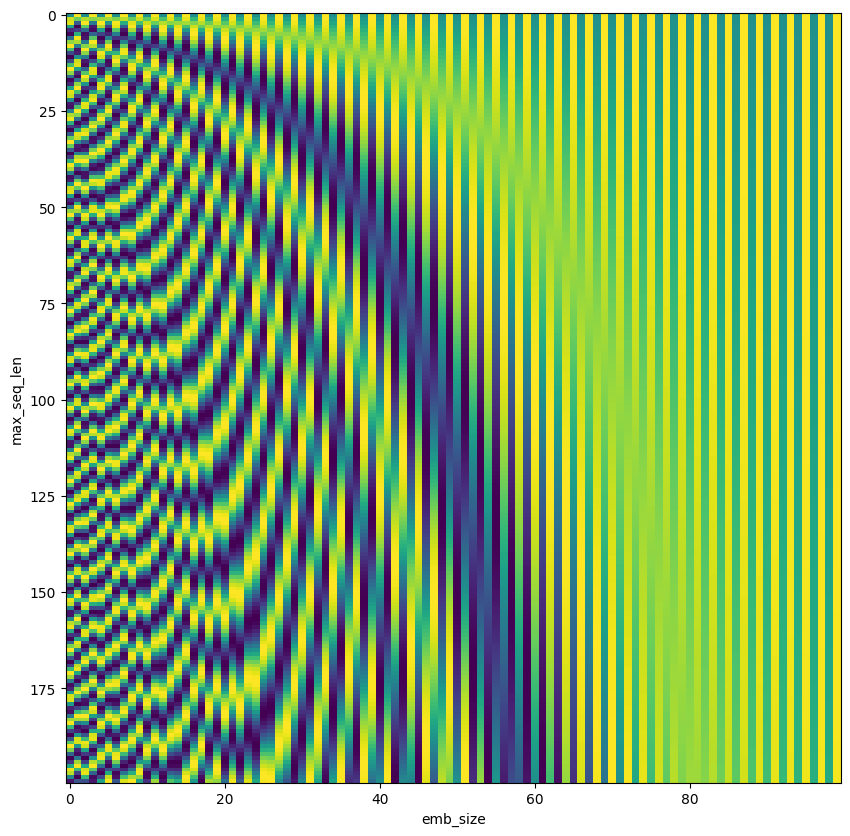

In [24]:
tmp_layer = PositionalEncoding(
    max_seq_len=200,
    emb_size=100,
)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, :, :], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

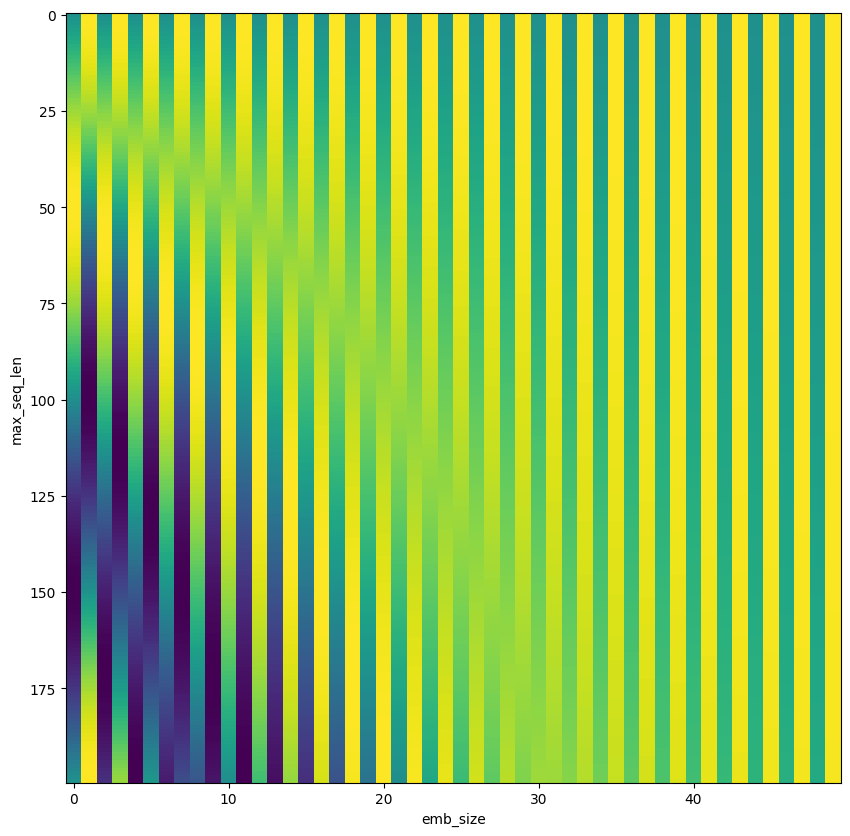

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, :, 50:], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

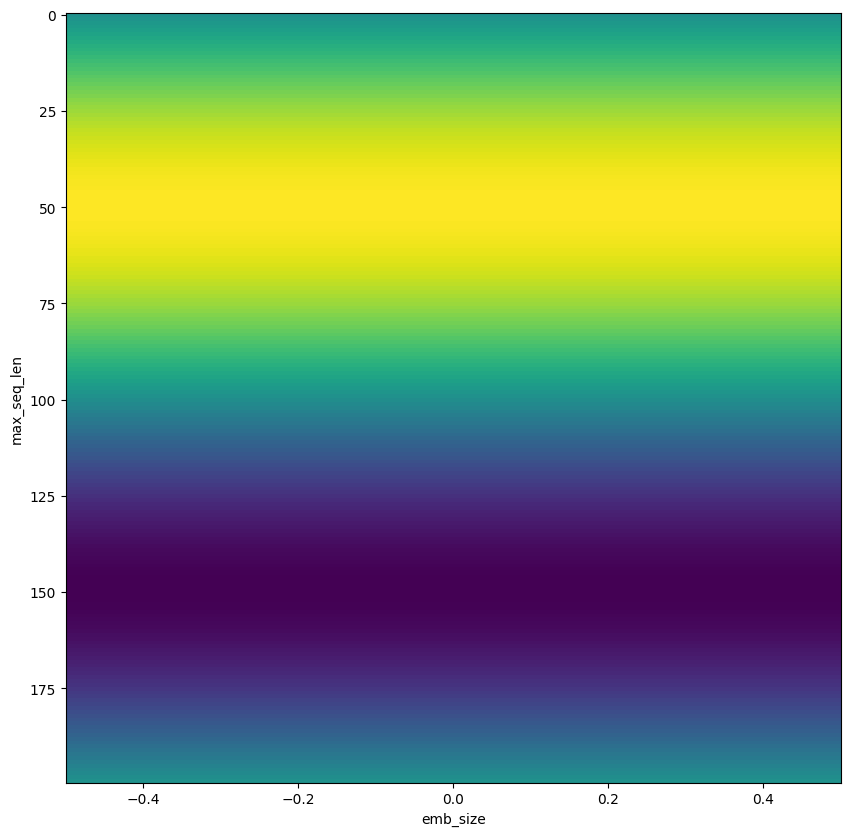

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, :, 50:51], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

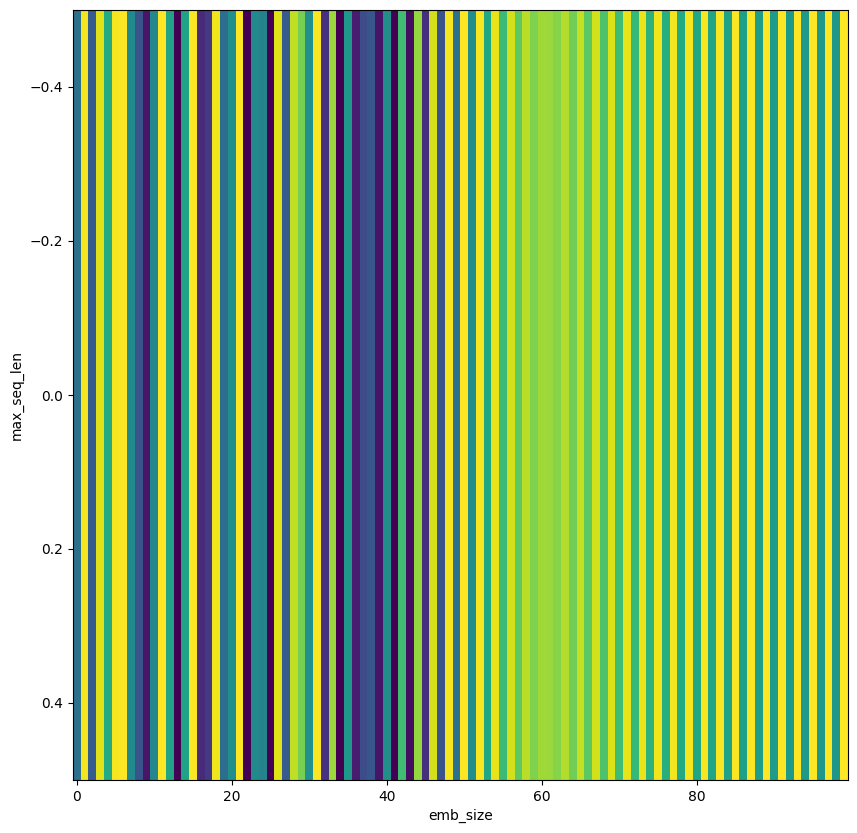

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, 50:51, :], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

### 1.3 Encoder

#### Картинка

<img src="https://www.researchgate.net/profile/Ehsan-Amjadian/publication/352239001/figure/fig1/AS:1033334390013952@1623377525434/Detailed-view-of-a-transformer-encoder-block-It-first-passes-the-input-through-an.jpg" width=500>

#### TransformerEncoderBlock

**Инициализация:**
* _in_size_ ~ размер эмбеддингов на входе
* _head_size_ ~ размер эмбеддингов матриц Q, K, V после преобразования
* _num_heads_ ~ число голов attention
* _out_size_ ~ размер эмбеддингов на выходе attention и блока
* _ff_hidden_size_ ~ размер скрытого представления для линейных слоёв
* _dropout_p_ ~ вероятность для dropout-ов
* _query_in_size_ ~ размер эмбеддингов на входе для query (если None, то in_size)

**Forward:**
* _query, key, value_ ~ 3 тензора (по одному под Q, K и V преобразования - это ещё не сами тензоры $\text{batch\_size} \times seq \times d_k$, а тензоры $\text{batch\_size} \times seq \times \text{in\_size}$)

In [28]:
class TransformerEncoderBlock(nn.Module):
    """
    Class with one full block within transformer's encoder
    """
    def __init__(self, in_size, head_size, num_heads, out_size, ff_hidden_size, dropout_p=0.2, query_in_size=None):
        """
        Args:
           in_size: input embedding size
           head_size: size of each attention head
           num_heads: number of attention heads
           out_size: output embedding size
           ff_hidden_size: hidden size for feed forward net
           dropout_p: probability for dropout
           query_in_size: embedding size of input for query (if not provided - same as in_size)
        """
        super(TransformerEncoderBlock, self).__init__()
        
        # Запишем все переданые гиперпараметры слоя
        self.in_size = in_size
        self.head_size = head_size
        self.num_heads = num_heads
        self.out_size = out_size
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        self.query_in_size = in_size if query_in_size is None else query_in_size
        
        self.attention = MultiHeadAttention(self.in_size, self.head_size, self.num_heads, self.out_size, self.query_in_size)
        # Если выход и вход attention-а имеют разный размер, то используем линейный слой на residual connection-е
        self.adapt_residual = nn.Linear(self.query_in_size, self.out_size) if self.query_in_size != self.out_size else nn.Identity()
        
        self.norm_1 = nn.LayerNorm(self.out_size)
        self.dropout_1 = nn.Dropout(self.dropout_p)
        
        self.feed_forward = nn.Sequential(OrderedDict([
            ("lin_1", nn.Linear(self.out_size, self.ff_hidden_size)),
            ("act", nn.ReLU()),
            ("lin_2", nn.Linear(self.ff_hidden_size, self.out_size)),
        ]))

        self.norm_2 = nn.LayerNorm(self.out_size)
        self.dropout_2 = nn.Dropout(self.dropout_p)
        

    def forward(self, query, key, value):
        """
        Args:
           block_input: input to corresponding block
        """
        # Получаем на вход 3 тензора batch_size x seq_len x in_size
        attention_out = self.attention(query, key, value)  # (batch_size, seq_len, out_size)
        attention_residual_out = attention_out + self.adapt_residual(query)
        norm_1_out = self.dropout_1(self.norm_1(attention_residual_out))

        # (batch_size, seq_len, out_size) -> (batch_size, seq_len, ff_hidden_size) -> (batch_size, seq_len, out_size)
        ff_out = self.feed_forward(norm_1_out)
        ff_residual_out = ff_out + norm_1_out
        return self.dropout_2(self.norm_2(ff_residual_out))

#### Протестируем TransformerEncoderBlock для энкодера

In [33]:
# Проверяем в обычном прямом проходе из энкодера
tmp_layer = TransformerEncoderBlock(
    in_size=10,
    head_size=7,
    num_heads=2,
    out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
)

tmp_layer

TransformerEncoderBlock(
  (attention): MultiHeadAttention(
    (query_matrix): Linear(in_features=10, out_features=14, bias=False)
    (key_matrix): Linear(in_features=10, out_features=14, bias=False)
    (value_matrix): Linear(in_features=10, out_features=14, bias=False)
    (out): Linear(in_features=14, out_features=15, bias=False)
  )
  (adapt_residual): Linear(in_features=10, out_features=15, bias=True)
  (norm_1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_1): Dropout(p=0.1, inplace=False)
  (feed_forward): Sequential(
    (lin_1): Linear(in_features=15, out_features=20, bias=True)
    (act): ReLU()
    (lin_2): Linear(in_features=20, out_features=15, bias=True)
  )
  (norm_2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_2): Dropout(p=0.1, inplace=False)
)

In [34]:
tmp_input = torch.rand(2, 5, 10)

print("Encoder-like input")
print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input, tmp_input, tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

Encoder-like input
Input shape: torch.Size([2, 5, 10])
Output shape: torch.Size([2, 5, 15])


#### Протестируем TransformerEncoderBlock для декодера

In [31]:
tmp_layer = TransformerEncoderBlock(
    in_size=10,
    head_size=7,
    num_heads=2,
    out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
    query_in_size=12,
)

tmp_layer

TransformerEncoderBlock(
  (attention): MultiHeadAttention(
    (query_matrix): Linear(in_features=12, out_features=14, bias=False)
    (key_matrix): Linear(in_features=10, out_features=14, bias=False)
    (value_matrix): Linear(in_features=10, out_features=14, bias=False)
    (out): Linear(in_features=14, out_features=15, bias=False)
  )
  (adapt_residual): Linear(in_features=12, out_features=15, bias=True)
  (norm_1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_1): Dropout(p=0.1, inplace=False)
  (feed_forward): Sequential(
    (lin_1): Linear(in_features=15, out_features=20, bias=True)
    (act): ReLU()
    (lin_2): Linear(in_features=20, out_features=15, bias=True)
  )
  (norm_2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_2): Dropout(p=0.1, inplace=False)
)

In [165]:
# Проверяем в прямом проходе из декодера, где мы смешиваем информацию из энкодера и декодера
tmp_input_q = torch.rand(2, 5, 12)
tmp_input_kv = torch.rand(2, 7, 10)

print("Encoder+Decoder-like input")
print(f'Input Q shape: {tmp_input_q.shape}')
print(f'Input KV shape: {tmp_input_kv.shape}')

tmp_output = tmp_layer(tmp_input_q, tmp_input_kv, tmp_input_kv)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_q, tmp_input_kv, tmp_output

Encoder+Decoder-like input
Input Q shape: torch.Size([2, 5, 12])
Input KV shape: torch.Size([2, 7, 10])
Output shape: torch.Size([2, 5, 15])


#### TransformerEncoder

**Инициализация:**
* _max_seq_len_ ~ максимальный размер в токенах последовательности
* _vocab_size_ ~ размер словаря
* _emb_size_ ~ размер эмбеддингов на входе
* _num_layers_ ~ число TransformerEncoderBlock-ов
* _att_out_size_ ~ размер эмбеддингов на выходе attention и блока
* _att_head_size_ ~ размер эмбеддингов матриц Q, K, V после преобразования
* _num_heads_ ~ число голов attention
* _ff_hidden_size_ ~ размер скрытого представления для линейных слоёв
* _dropout_p_ ~ вероятность для dropout-ов

**Forward:**
* _encoder_input_ ~ токены входа в энкодер до эмбеддингов

In [35]:
class TransformerEncoder(nn.Module):
    """
    Class for encoder within transformer.
    """
    def __init__(self, max_seq_len, vocab_size, emb_size, num_layers, att_out_size, att_head_size, num_heads, ff_hidden_size, dropout_p):
        """
        Args:
            max_seq_len : maximum length of input sequence
            vocab_size: size of the vocabulary
            emb_size: embeddings size
            num_layers: number of encoder layers
            att_out_size: output size for attention and each encoder block
            att_head_size: size of each attention head
            num_heads: number of heads in multihead attention
            ff_hidden_size: hidden size for feed forward net
            dropout_p: probability for dropout
        """
        super(TransformerEncoder, self).__init__()
        
        # Запишем все переданые гиперпараметры слоя
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_layers = num_layers
        self.att_out_size = att_out_size
        self.att_head_size = att_head_size
        self.num_heads = num_heads
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        
        self.embedding_layer = nn.Embedding(self.vocab_size, self.emb_size)
        self.positional_encoder = PositionalEncoding(self.max_seq_len, self.emb_size)

        # Красивая обёртка для модулей в dict
        self.encoder_blocks = nn.ModuleDict({
            f"encoder_block_{i}": TransformerEncoderBlock(
                in_size=self.emb_size if i==0 else self.att_out_size,
                head_size=self.att_head_size,
                num_heads=self.num_heads,
                out_size=self.att_out_size,
                ff_hidden_size=self.ff_hidden_size,
                dropout_p=self.dropout_p,
            ) for i in range(self.num_layers)
        })
    
    def forward(self, encoder_input):
        # Получаем на вход batch_size x seq_len
        encoder_emb = self.embedding_layer(encoder_input)  # (batch_size, seq_len, emb_size)
        out = self.positional_encoder(encoder_emb)
        for block in self.encoder_blocks.values():
            out = block(out, out, out)  # (batch_size, seq_len, att_out_size)

        return out

#### Протестируем TransformerEncoder

In [36]:
tmp_layer = TransformerEncoder(
    max_seq_len=20,
    vocab_size=10000,
    emb_size=10,
    num_layers=2,
    att_head_size=7,
    num_heads=2,
    att_out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
)

tmp_layer

TransformerEncoder(
  (embedding_layer): Embedding(10000, 10)
  (positional_encoder): PositionalEncoding()
  (encoder_blocks): ModuleDict(
    (encoder_block_0): TransformerEncoderBlock(
      (attention): MultiHeadAttention(
        (query_matrix): Linear(in_features=10, out_features=14, bias=False)
        (key_matrix): Linear(in_features=10, out_features=14, bias=False)
        (value_matrix): Linear(in_features=10, out_features=14, bias=False)
        (out): Linear(in_features=14, out_features=15, bias=False)
      )
      (adapt_residual): Linear(in_features=10, out_features=15, bias=True)
      (norm_1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
      (dropout_1): Dropout(p=0.1, inplace=False)
      (feed_forward): Sequential(
        (lin_1): Linear(in_features=15, out_features=20, bias=True)
        (act): ReLU()
        (lin_2): Linear(in_features=20, out_features=15, bias=True)
      )
      (norm_2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
      (drop

In [37]:
tmp_input = torch.randint(10000, (2, 5))

print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

Input shape: torch.Size([2, 5])
Output shape: torch.Size([2, 5, 15])


### 1.4 Decoder

#### Картинка

<img src="https://i.pinimg.com/736x/c1/83/1a/c1831a58ecc935fc0f2ef4d35ce4fddb.jpg" width=500>

#### TransformerDecoderBlock

**Инициализация:**
* _in_size_ ~ размер эмбеддингов на входе
* _head_size_ ~ размер эмбеддингов матриц Q, K, V после преобразования
* _num_heads_ ~ число голов attention
* _out_size_ ~ размер эмбеддингов на выходе attention и блока
* _ff_hidden_size_ ~ размер скрытого представления для линейных слоёв
* _dropout_p_ ~ вероятность для dropout-ов
* _encoder_out_size_ ~ размер эмбеддингов на выходе энкодера (если None, то in_size)

**Forward:**
* _decoder_emb_ ~ тензор, пришедший из предыдущего блока, или эмбеддинги с позиционными
* _encoder_output_ ~ выходной тензор из соответствующего энкодера

In [38]:
class TransformerDecoderBlock(nn.Module):
    """
    Class with one full block within transformer's decoder
    """
    def __init__(self, in_size, head_size, num_heads, out_size, ff_hidden_size, dropout_p=0.2, encoder_out_size=None):
        """
        Args:
           in_size: input embedding size
           head_size: size of each attention head
           num_heads: number of attention heads
           out_size: output embedding size
           ff_hidden_size: hidden size for feed forward net
           dropout_p: probability for dropout
           encoder_out_size: embedding size of outputs from encoder (if not provided - same as in_size)
        """
        super(TransformerDecoderBlock, self).__init__()
        
        # Запишем все переданые гиперпараметры слоя
        self.in_size = in_size
        self.head_size = head_size
        self.num_heads = num_heads
        self.out_size = out_size
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        self.encoder_out_size = in_size if encoder_out_size is None else encoder_out_size
        
        
        self.masked_attention = MultiHeadAttention(self.in_size, self.head_size, self.num_heads, self.out_size)
        # Если выход и вход attention-а имеют разный размер, то используем линейный слой на residual connection-е
        self.adapt_residual = nn.Linear(self.in_size, self.out_size) if self.in_size != self.out_size else nn.Identity()
        self.norm = nn.LayerNorm(self.out_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.encoder_block = TransformerEncoderBlock(self.encoder_out_size, self.head_size, self.num_heads, self.out_size, self.ff_hidden_size, self.dropout_p, self.out_size)
        
    
    def forward(self, decoder_emb, encoder_output):
        """
        Args:
           decoder_emb: decoder sequence after embed
           encoder_output: output from encoder
        """
        # Получаем на вход тензор batch_size x seq_len x in_size и тензор batch_size x encoder_seq_len x encoder_out_size
        mask = make_decoder_mask(decoder_emb)  # batch_size x 1 x seq_len x seq_len
        attention = self.masked_attention(decoder_emb, decoder_emb, decoder_emb, mask=mask)  # batch_size x seq_len x out_size
        mmha_out = self.dropout(self.norm(attention + self.adapt_residual(decoder_emb)))
        
        return self.encoder_block(mmha_out, encoder_output, encoder_output)  # batch_size x seq_len x out_size

#### Протестируем TransformerDecoderBlock

In [39]:
tmp_layer = TransformerDecoderBlock(
    in_size=10,
    head_size=7,
    num_heads=2,
    out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
    encoder_out_size=12,
)

tmp_layer

TransformerDecoderBlock(
  (masked_attention): MultiHeadAttention(
    (query_matrix): Linear(in_features=10, out_features=14, bias=False)
    (key_matrix): Linear(in_features=10, out_features=14, bias=False)
    (value_matrix): Linear(in_features=10, out_features=14, bias=False)
    (out): Linear(in_features=14, out_features=15, bias=False)
  )
  (adapt_residual): Linear(in_features=10, out_features=15, bias=True)
  (norm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder_block): TransformerEncoderBlock(
    (attention): MultiHeadAttention(
      (query_matrix): Linear(in_features=15, out_features=14, bias=False)
      (key_matrix): Linear(in_features=12, out_features=14, bias=False)
      (value_matrix): Linear(in_features=12, out_features=14, bias=False)
      (out): Linear(in_features=14, out_features=15, bias=False)
    )
    (adapt_residual): Identity()
    (norm_1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
   

In [40]:
# Проверяем в прямом проходе из декодера, где мы смешиваем информацию из энкодера и декодера
tmp_input_decoder = torch.rand(2, 5, 10)
tmp_output_encoder = torch.rand(2, 7, 12)

print("Encoder+Decoder-like input")
print(f'Decoder input shape: {tmp_input_decoder.shape}')
print(f'Encoder output shape: {tmp_output_encoder.shape}')

tmp_output = tmp_layer(tmp_input_decoder, tmp_output_encoder)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_decoder, tmp_output_encoder

Encoder+Decoder-like input
Decoder input shape: torch.Size([2, 5, 10])
Encoder output shape: torch.Size([2, 7, 12])
Output shape: torch.Size([2, 5, 15])


#### TransformerDecoder

**Инициализация:**
* _max_seq_len_ ~ максимальный размер в токенах последовательности
* _vocab_size_ ~ размер словаря
* _emb_size_ ~ размер эмбеддингов на входе
* _num_layers_ ~ число TransformerEncoderBlock-ов
* _att_out_size_ ~ размер эмбеддингов на выходе attention и блока
* _att_head_size_ ~ размер эмбеддингов матриц Q, K, V после преобразования
* _num_heads_ ~ число голов attention
* _ff_hidden_size_ ~ размер скрытого представления для линейных слоёв
* _dropout_p_ ~ вероятность для dropout-ов
* _encoder_out_size_ ~ размер эмбеддингов на выходе энкодера (если None, то in_size)

**Forward:**
* _decoder_input_ ~ токены входа в декодер до эмбеддингов
* _encoder_output_ ~ выходной тензор из соответствующего энкодера

In [42]:
class TransformerDecoder(nn.Module):
    """
    Class for decoder within transformer.
    """
    def __init__(self, max_seq_len, vocab_size, emb_size, num_layers, att_out_size, att_head_size, num_heads, ff_hidden_size, dropout_p, encoder_out_size=None):
        """  
        Args:
            max_seq_len : maximum length of input sequence
            vocab_size: size of the vocabulary
            emb_size: embeddings size
            num_layers: number of encoder layers
            att_out_size: output size for attention and each encoder block
            att_head_size: size of each attention head
            num_heads: number of heads in multihead attention
            ff_hidden_size: hidden size for feed forward net
            dropout_p: probability for dropout
            encoder_out_size: embedding size of outputs from encoder (if not provided - same as in_size)
        """
        super(TransformerDecoder, self).__init__()
                
        # Запишем все переданые гиперпараметры слоя
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_layers = num_layers
        self.att_out_size = att_out_size
        self.att_head_size = att_head_size
        self.num_heads = num_heads
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        self.encoder_out_size = emb_size if encoder_out_size is None else encoder_out_size
        
        self.embedding_layer = nn.Embedding(self.vocab_size, self.emb_size)
        self.positional_encoder = PositionalEncoding(self.max_seq_len, self.emb_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.decoder_blocks = nn.ModuleDict({
            f"decoder_block_{i}": TransformerDecoderBlock(
                in_size=self.emb_size if i==0 else self.att_out_size,
                head_size=self.att_head_size,
                num_heads=self.num_heads,
                out_size=self.att_out_size,
                ff_hidden_size=self.ff_hidden_size,
                dropout_p=self.dropout_p,
                encoder_out_size=self.encoder_out_size,
            ) for i in range(self.num_layers)
        })
        
        self.fc = nn.Linear(self.att_out_size, self.vocab_size)

    def forward(self, decoder_input, encoder_output):
        """
        Args:
            decoder_input:
            encoder_output:
        Returns:
            out: output vector
        """
        # Получаем на вход batch_size x seq_len и batch_size x encoder_seq_len x encoder_out_size
        decoder_emb = self.embedding_layer(decoder_input)  # batch_size x seq_len x emb_size
        decoder_emb = self.positional_encoder(decoder_emb)
        
        out = self.dropout(decoder_emb)
     
        for block in self.decoder_blocks.values():
            out = block(out, encoder_output)  # batch_size x seq_len x att_out_size

        return self.fc(out)

#### Протестируем TransformerDecoder

In [43]:
tmp_layer = TransformerDecoder(
    max_seq_len=20,
    vocab_size=10000,
    emb_size=10,
    num_layers=2,
    att_head_size=7,
    num_heads=2,
    att_out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
    encoder_out_size=12,
)

tmp_layer

TransformerDecoder(
  (embedding_layer): Embedding(10000, 10)
  (positional_encoder): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (decoder_blocks): ModuleDict(
    (decoder_block_0): TransformerDecoderBlock(
      (masked_attention): MultiHeadAttention(
        (query_matrix): Linear(in_features=10, out_features=14, bias=False)
        (key_matrix): Linear(in_features=10, out_features=14, bias=False)
        (value_matrix): Linear(in_features=10, out_features=14, bias=False)
        (out): Linear(in_features=14, out_features=15, bias=False)
      )
      (adapt_residual): Linear(in_features=10, out_features=15, bias=True)
      (norm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder_block): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=15, out_features=14, bias=False)
          (key_matrix): Linear(in_features=12, out_features=14, bia

In [44]:
# Проверяем в прямом проходе из декодера, где мы смешиваем информацию из энкодера и декодера
tmp_input_decoder = torch.randint(10000, (2, 5))
tmp_output_encoder = torch.rand(2, 7, 12)

print("Encoder+Decoder-like input")
print(f'Decoder input shape: {tmp_input_decoder.shape}')
print(f'Encoder output shape: {tmp_output_encoder.shape}')

tmp_output = tmp_layer(tmp_input_decoder, tmp_output_encoder)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_decoder, tmp_output_encoder

Encoder+Decoder-like input
Decoder input shape: torch.Size([2, 5])
Encoder output shape: torch.Size([2, 7, 12])
Output shape: torch.Size([2, 5, 10000])


### 1.5 Transformer

In [49]:
class Transformer(nn.Module):
    """
    Class for full encoder-deccoder transformer
    """
    def __init__(
        self,
        max_seq_len,
        vocab_size,
        emb_size,
        
        num_encoder_layers,
        enc_att_out_size,
        enc_att_head_size,
        enc_num_heads,
        enc_ff_hidden_size,
        enc_dropout_p,
        
        num_decoder_layers,
        dec_att_out_size,
        dec_att_head_size,
        dec_num_heads,
        dec_ff_hidden_size,
        dec_dropout_p,
    ):
        super(Transformer, self).__init__()
        
        # Запишем все переданые гиперпараметры модели
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.num_encoder_layers = num_encoder_layers
        self.enc_att_out_size = enc_att_out_size
        self.enc_att_head_size = enc_att_head_size
        self.enc_num_heads = enc_num_heads
        self.enc_ff_hidden_size = enc_ff_hidden_size
        self.enc_dropout_p = enc_dropout_p
        
        self.num_decoder_layers = num_decoder_layers
        self.dec_att_out_size = dec_att_out_size
        self.dec_att_head_size = dec_att_head_size
        self.dec_num_heads = dec_num_heads
        self.dec_ff_hidden_size = dec_ff_hidden_size
        self.dec_dropout_p = dec_dropout_p

        # Encoder
        self.encoder = TransformerEncoder(
            max_seq_len=self.max_seq_len,
            vocab_size=self.vocab_size,
            emb_size=self.emb_size,
            num_layers=self.num_encoder_layers,
            att_head_size=self.enc_att_head_size,
            num_heads=self.enc_num_heads,
            att_out_size=self.enc_att_out_size,
            ff_hidden_size=self.enc_ff_hidden_size,
            dropout_p=self.enc_dropout_p,
        )
        
        # Decoder
        self.decoder = TransformerDecoder(
            max_seq_len=self.max_seq_len,
            vocab_size=self.vocab_size,
            emb_size=self.emb_size,
            num_layers=self.num_decoder_layers,
            att_head_size=self.dec_att_head_size,
            num_heads=self.dec_num_heads,
            att_out_size=self.dec_att_out_size,
            ff_hidden_size=self.dec_ff_hidden_size,
            dropout_p=self.dec_dropout_p,
            encoder_out_size=self.enc_att_out_size,
        )
    
    def forward(self, encoder_input, decoder_input):
        """
        Args:
            encoder_input: input to encoder 
            decoder_input: input to decoder
        out:
            out: final tensor with logits of each word in vocab
        """
        # Получаем на вход batch_size x enc_seq_len и batch_size x dec_seq_len
        encoder_output = self.encoder(encoder_input)  # (batch_size, enc_seq_len, enc_att_out_size)
   
        return self.decoder(decoder_input, encoder_output)  # (batch_size, dec_seq_len, vocab_size)

### 1.6 Тестируем

In [50]:
tmp_layer = Transformer(
    max_seq_len=20,
    vocab_size=10000,
    emb_size=10,
    
    num_encoder_layers=3,
    enc_att_head_size=7,
    enc_num_heads=3,
    enc_att_out_size=20,
    enc_ff_hidden_size=30,
    enc_dropout_p=0.2,
    
    num_decoder_layers=2,
    dec_att_head_size=7,
    dec_num_heads=2,
    dec_att_out_size=15,
    dec_ff_hidden_size=20,
    dec_dropout_p=0.1,
)

tmp_layer

Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(10000, 10)
    (positional_encoder): PositionalEncoding()
    (encoder_blocks): ModuleDict(
      (encoder_block_0): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=10, out_features=21, bias=False)
          (key_matrix): Linear(in_features=10, out_features=21, bias=False)
          (value_matrix): Linear(in_features=10, out_features=21, bias=False)
          (out): Linear(in_features=21, out_features=20, bias=False)
        )
        (adapt_residual): Linear(in_features=10, out_features=20, bias=True)
        (norm_1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout_1): Dropout(p=0.2, inplace=False)
        (feed_forward): Sequential(
          (lin_1): Linear(in_features=20, out_features=30, bias=True)
          (act): ReLU()
          (lin_2): Linear(in_features=30, out_features=20, bias=True)
        )
        (norm_2): 

In [51]:
tmp_input_encoder = torch.randint(10000, (2, 9))
tmp_input_decoder = torch.randint(10000, (2, 5))

print(f'Encoder input shape: {tmp_input_encoder.shape}')
print(f'Decoder input shape: {tmp_input_decoder.shape}')

tmp_output = tmp_layer(tmp_input_encoder, tmp_input_decoder)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_decoder, tmp_input_encoder

Encoder input shape: torch.Size([2, 9])
Decoder input shape: torch.Size([2, 5])
Output shape: torch.Size([2, 5, 10000])


### 1.7 Авторегрессия

In [48]:
model = Transformer(
    max_seq_len=20,
    vocab_size=10000,
    emb_size=10,
    
    num_encoder_layers=1,
    enc_att_head_size=7,
    enc_num_heads=3,
    enc_att_out_size=20,
    enc_ff_hidden_size=30,
    enc_dropout_p=0.2,
    
    num_decoder_layers=1,
    dec_att_head_size=7,
    dec_num_heads=2,
    dec_att_out_size=15,
    dec_ff_hidden_size=20,
    dec_dropout_p=0.1,
)

model

Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(10000, 10)
    (positional_encoder): PositionalEncoding()
    (encoder_blocks): ModuleDict(
      (encoder_block_0): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=10, out_features=21, bias=False)
          (key_matrix): Linear(in_features=10, out_features=21, bias=False)
          (value_matrix): Linear(in_features=10, out_features=21, bias=False)
          (out): Linear(in_features=21, out_features=20, bias=False)
        )
        (adapt_residual): Linear(in_features=10, out_features=20, bias=True)
        (norm_1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout_1): Dropout(p=0.2, inplace=False)
        (feed_forward): Sequential(
          (lin_1): Linear(in_features=20, out_features=30, bias=True)
          (act): ReLU()
          (lin_2): Linear(in_features=30, out_features=20, bias=True)
        )
        (norm_2): 

In [52]:
def generate(model, encoder_input, decoder_input, max_seq_len, eos_ind=1):
    model.eval()
    with torch.no_grad():
        encoder_output = model.encoder(encoder_input)

        decoder_input_len = decoder_input.shape[1]
        num_generated = 0
        is_eos = torch.zeros(decoder_input.shape[0]).bool()
        while decoder_input_len + num_generated < max_seq_len and any(is_eos == False):
            decoder_output = model.decoder(decoder_input, encoder_output)  # batch_size x dec_seq_len x vocab_size
            pred_logits = decoder_output[:, -1, :]
            pred_tokens = torch.max(F.softmax(pred_logits, -1), dim=-1).indices
            is_eos |= (pred_tokens == eos_ind)
            decoder_input = torch.cat((decoder_input, pred_tokens[:, None]), dim=-1)
            num_generated += 1
    
    return decoder_input[:, decoder_input_len:]

In [53]:
generate(
    model=model,
    encoder_input=torch.randint(10000, (2, 5)),
    decoder_input=torch.randint(10000, (2, 1)),
    max_seq_len=5,
    eos_ind=1,
).shape

torch.Size([2, 4])

### 1.8 Дополнительно

In [144]:
?torch.nn.Transformer

Init signature:
torch.nn.Transformer(
    d_model: int = 512,
    nhead: int = 8,
    num_encoder_layers: int = 6,
    num_decoder_layers: int = 6,
    dim_feedforward: int = 2048,
    dropout: float = 0.1,
    activation: Union[str, Callable[[torch.Tensor], torch.Tensor]] = <function relu at 0x7f00012723b0>,
    custom_encoder: Union[Any, NoneType] = None,
    custom_decoder: Union[Any, NoneType] = None,
    layer_norm_eps: float = 1e-05,
    batch_first: bool = False,
    norm_first: bool = False,
    device=None,
    dtype=None,
) -> None
Docstring:     
A transformer model. User is able to modify the attributes as needed. The architecture
is based on the paper "Attention Is All You Need". Ashish Vaswani, Noam Shazeer,
Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and
Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information
Processing Systems, pages 6000-6010.

Args:
    d_model: the number of expected features in the encoder/de